Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt

%matplotlib inline

/home/dmitry/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) 
            / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
batch_size = 128
image_size = 28
num_labels = 10

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataste = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    W_1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    b_1 = tf.Variable(tf.zeros([num_labels]))
    
    logits = tf.matmul(tf_train_dataset, W_1) + b_1
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) + beta * tf.nn.l2_loss(W_1))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, W_1) + b_1)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataste, W_1) + b_1)
    
    train_correct_prediction = tf.equal(tf.argmax(tf_train_labels, 1), tf.argmax(train_prediction, 1))
    train_accuracy = tf.reduce_mean(tf.cast(train_correct_prediction, tf.float32))
    

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    log_losses = []
    log_accuracy = []
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: 0.01}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        log_losses.append(l)
        log_accuracy.append(accuracy(predictions, batch_labels))
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 48.471642
Minibatch accuracy: 7.0%
Validation accuracy: 13.5%
Minibatch loss at step 500: 0.971481
Minibatch accuracy: 78.9%
Validation accuracy: 81.0%
Minibatch loss at step 1000: 0.540438
Minibatch accuracy: 89.8%
Validation accuracy: 80.8%
Minibatch loss at step 1500: 0.697854
Minibatch accuracy: 83.6%
Validation accuracy: 81.4%
Minibatch loss at step 2000: 0.854202
Minibatch accuracy: 77.3%
Validation accuracy: 80.5%
Minibatch loss at step 2500: 0.664051
Minibatch accuracy: 85.2%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.727746
Minibatch accuracy: 80.5%
Validation accuracy: 80.6%
Test accuracy: 87.5%


In [7]:
%%time
betas = [pow(10, i)  for i in np.arange(-4, -1, 0.25)]
num_steps = 3001

valid_accuracy = []
test_accuracy = []

for beta_v in betas:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_v}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
        test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
    

CPU times: user 2min 14s, sys: 14 s, total: 2min 28s
Wall time: 1min 51s


[]

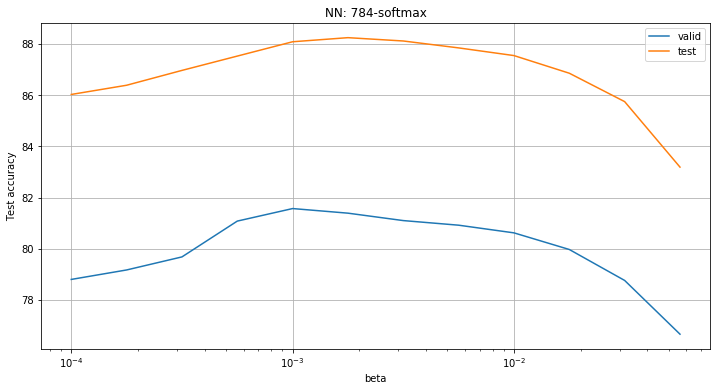

In [8]:
plt.figure(figsize=(12, 6))
plt.semilogx(betas, valid_accuracy, label='valid')
plt.semilogx(betas, test_accuracy, label='test')
plt.grid()
plt.legend()
plt.title("NN: 784-softmax")
plt.xlabel("beta")
plt.ylabel("Test accuracy")
plt.plot()

In [9]:
batch_size = 128
image_size = 28
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    # First layer (variables and computations).
    W_1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_hidden_nodes]))
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    logits_1 = tf.matmul(tf_train_dataset, W_1) + b_1
    relu_1 = tf.nn.relu(logits_1)
    
    # Second layer.
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    b_2 = tf.Variable(tf.zeros([num_labels]))
    logits_2 = tf.matmul(relu_1, W_2) + b_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_2)) +\
    beta * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits_2)
    layer_1_val = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer_1_val, W_2) + b_2)    
    layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_prediction = tf.nn.softmax(tf.matmul(layer_1_test, W_2) + b_2)

In [10]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    nn_losses = []
    nn_accuracy = []
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: 0.01}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        nn_losses.append(l)
        nn_accuracy.append(accuracy(predictions, batch_labels))
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3500.679199
Minibatch accuracy: 7.8%
Validation accuracy: 30.1%
Minibatch loss at step 500: 21.272594
Minibatch accuracy: 85.2%
Validation accuracy: 85.1%
Minibatch loss at step 1000: 0.687332
Minibatch accuracy: 89.8%
Validation accuracy: 82.9%
Minibatch loss at step 1500: 0.631106
Minibatch accuracy: 86.7%
Validation accuracy: 83.8%
Minibatch loss at step 2000: 0.781760
Minibatch accuracy: 82.0%
Validation accuracy: 83.1%
Minibatch loss at step 2500: 0.653400
Minibatch accuracy: 86.7%
Validation accuracy: 83.4%
Minibatch loss at step 3000: 0.718009
Minibatch accuracy: 84.4%
Validation accuracy: 83.5%
Test accuracy: 90.0%


In [11]:
%%time
betas = [pow(10, i)  for i in np.arange(-4, -1, 0.25)]
num_steps = 3001

valid_accuracy = []
test_accuracy = []

for beta_v in betas:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: beta_v}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
        test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
    

CPU times: user 39min 59s, sys: 3min 27s, total: 43min 27s
Wall time: 32min 18s


[]

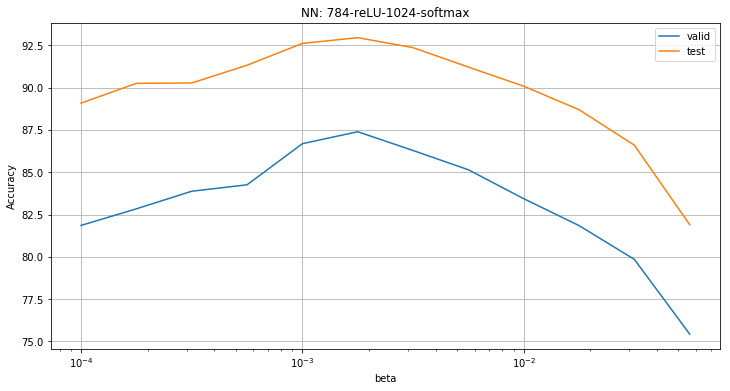

In [12]:
plt.figure(figsize=(12, 6))
plt.semilogx(betas, valid_accuracy, label='valid')
plt.semilogx(betas, test_accuracy, label='test')
plt.grid()
plt.legend()
plt.title("NN: 784-reLU-1024-softmax")
plt.xlabel("beta")
plt.ylabel("Test accuracy")
plt.plot()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

A few batches without regularization.

In [13]:
batch_size = 128
image_size = 28
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # First layer (variables and computations).
    W_1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_hidden_nodes]))
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    logits_1 = tf.matmul(tf_train_dataset, W_1) + b_1
    relu_1 = tf.nn.relu(logits_1)
    
    # Second layer.
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    b_2 = tf.Variable(tf.zeros([num_labels]))
    logits_2 = tf.matmul(relu_1, W_2) + b_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_2))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits_2)
    layer_1_val = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer_1_val, W_2) + b_2)    
    layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_prediction = tf.nn.softmax(tf.matmul(layer_1_test, W_2) + b_2)

In [14]:
num_steps = 3001
num_batches = 5
small_train_dataset = train_dataset[:batch_size*num_batches, :]
small_train_labels = train_labels[:batch_size*num_batches, :]

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = small_train_dataset[offset:(offset + batch_size), :]
        batch_labels = small_train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 383.819885
Minibatch accuracy: 10.9%
Validation accuracy: 36.4%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.0%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.9%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.9%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.9%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.9%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.9%
Test accuracy: 81.5%


A few batches with regularization.

In [15]:
batch_size = 128
image_size = 28
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    # First layer (variables and computations).
    W_1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_hidden_nodes]))
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    logits_1 = tf.matmul(tf_train_dataset, W_1) + b_1
    relu_1 = tf.nn.relu(logits_1)
    
    # Second layer.
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    b_2 = tf.Variable(tf.zeros([num_labels]))
    logits_2 = tf.matmul(relu_1, W_2) + b_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_2)) +\
    beta * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits_2)
    layer_1_val = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer_1_val, W_2) + b_2)    
    layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_prediction = tf.nn.softmax(tf.matmul(layer_1_test, W_2) + b_2)

In [16]:
num_steps = 3001
num_batches = 5
small_train_dataset = train_dataset[:batch_size*num_batches, :]
small_train_labels = train_labels[:batch_size*num_batches, :]

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = small_train_dataset[offset:(offset + batch_size), :]
        batch_labels = small_train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta: 0.01}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3539.280029
Minibatch accuracy: 12.5%
Validation accuracy: 36.2%
Minibatch loss at step 500: 21.051146
Minibatch accuracy: 100.0%
Validation accuracy: 78.2%
Minibatch loss at step 1000: 0.485157
Minibatch accuracy: 100.0%
Validation accuracy: 79.0%
Minibatch loss at step 1500: 0.318382
Minibatch accuracy: 100.0%
Validation accuracy: 79.0%
Minibatch loss at step 2000: 0.305720
Minibatch accuracy: 100.0%
Validation accuracy: 79.0%
Minibatch loss at step 2500: 0.299560
Minibatch accuracy: 100.0%
Validation accuracy: 79.0%
Minibatch loss at step 3000: 0.295808
Minibatch accuracy: 100.0%
Validation accuracy: 79.0%
Test accuracy: 85.3%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [17]:
batch_size = 128
num_hidden_nodes = 1024
image_size = 28
num_labels = 10

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    W_1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_hidden_nodes]))
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    b_2 = tf.Variable(tf.zeros([num_labels]))
    
    logits_1 = tf.matmul(tf_train_dataset, W_1) + b_1
    relu_1 = tf.nn.relu(logits_1)
    dropout_1 = tf.nn.dropout(relu_1, 0.5)
    logits_2 = tf.matmul(dropout_1, W_2) + b_2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_2))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits_2)
    layer_1_val = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer_1_val, W_2) + b_2)    
    layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_prediction = tf.nn.softmax(tf.matmul(layer_1_test, W_2) + b_2)

In [18]:
num_steps = 3001
num_batches = 5
small_train_dataset = train_dataset[:batch_size*num_batches, :]
small_train_labels = train_labels[:batch_size*num_batches, :]

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = small_train_dataset[offset:(offset + batch_size), :]
        batch_labels = small_train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 463.533112
Minibatch accuracy: 8.6%
Validation accuracy: 30.4%
Minibatch loss at step 500: 0.254597
Minibatch accuracy: 99.2%
Validation accuracy: 78.2%
Minibatch loss at step 1000: 0.000013
Minibatch accuracy: 100.0%
Validation accuracy: 78.1%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 77.7%
Minibatch loss at step 2000: 1.074104
Minibatch accuracy: 99.2%
Validation accuracy: 78.2%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 78.1%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 78.7%
Test accuracy: 85.3%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [20]:
batch_size = 128
image_size = 28
num_labels = 10
num_hidden_nodes_1 = 1024
num_hidden_nodes_2 = 512
num_hidden_nodes_3 = 128

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
  
    W_1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_hidden_nodes_1],
                                          stddev=np.sqrt(2.0/(image_size*image_size))))
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes_1]))
    
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes_1, num_hidden_nodes_2],
                                         stddev=np.sqrt(2.0/num_hidden_nodes_1)))
    b_2 = tf.Variable(tf.zeros([num_hidden_nodes_2]))
    
    W_3 = tf.Variable(tf.truncated_normal([num_hidden_nodes_2, num_hidden_nodes_3],
                                         stddev=np.sqrt(2.0/num_hidden_nodes_2)))
    b_3 = tf.Variable(tf.zeros([num_hidden_nodes_3]))
    
    W_4 = tf.Variable(tf.truncated_normal([num_hidden_nodes_3, num_labels],
                                         stddev=np.sqrt(2.0/num_hidden_nodes_3)))
    b_4 = tf.Variable(tf.zeros([num_labels]))
    
    
    logits_1 = tf.matmul(tf_train_dataset, W_1) + b_1
    relu_1 = tf.nn.relu(logits_1)
    dropout_1 = tf.nn.dropout(relu_1, 0.5)
    
    logits_2 = tf.matmul(dropout_1, W_2) + b_2
    relu_2 = tf.nn.relu(logits_2)
    dropout_2 = tf.nn.dropout(relu_2, 0.5)
    
    logits_3 = tf.matmul(dropout_2, W_3) + b_3
    relu_3 = tf.nn.relu(logits_3)
    dropout_3 = tf.nn.dropout(relu_3, 0.5)
    
    logits_4 = tf.matmul(dropout_3, W_4) + b_4
   
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_4))
    
    learning_rate = tf.train.exponential_decay(0.5, global_step, 100, 0.99, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    train_prediction = tf.nn.softmax(logits_4)
    
    valid_layer_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1)
    valid_layer_2 = tf.nn.relu(tf.matmul(valid_layer_1, W_2) + b_2)
    valid_layer_3 = tf.nn.relu(tf.matmul(valid_layer_2, W_3) + b_3)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_layer_3, W_4) + b_4)
    
    test_layer_1 = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_layer_2 = tf.nn.relu(tf.matmul(test_layer_1, W_2) + b_2)
    test_layer_3 = tf.nn.relu(tf.matmul(test_layer_2, W_3) + b_3)
    test_prediction = tf.nn.softmax(tf.matmul(test_layer_3, W_4) + b_4)

In [21]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    log_losses = []
    log_accuracy = []
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
               
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.823245
Minibatch accuracy: 15.6%
Validation accuracy: 22.6%
Minibatch loss at step 500: 0.561815
Minibatch accuracy: 82.8%
Validation accuracy: 84.1%
Minibatch loss at step 1000: 0.360744
Minibatch accuracy: 90.6%
Validation accuracy: 85.0%
Minibatch loss at step 1500: 0.443442
Minibatch accuracy: 86.7%
Validation accuracy: 85.6%
Minibatch loss at step 2000: 0.614143
Minibatch accuracy: 84.4%
Validation accuracy: 86.4%
Minibatch loss at step 2500: 0.463524
Minibatch accuracy: 86.7%
Validation accuracy: 86.9%
Minibatch loss at step 3000: 0.476858
Minibatch accuracy: 85.9%
Validation accuracy: 86.9%
Minibatch loss at step 3500: 0.400279
Minibatch accuracy: 88.3%
Validation accuracy: 87.6%
Minibatch loss at step 4000: 0.423101
Minibatch accuracy: 82.8%
Validation accuracy: 87.7%
Minibatch loss at step 4500: 0.533767
Minibatch accuracy: 82.8%
Validation accuracy: 88.3%
Minibatch loss at step 5000: 0.449781
Minibatch accuracy: 87.5%
Validation accurac